# SIFT (Scale-Invariant Feature Transform)
---

Harris corner detection are rotation-invariant, which means, even if the image is rotated, we can find the same corners. It is obvious because corners remain corners in rotated image also. But what about scaling? A corner may not be a corner if the image is scaled. For example, check a simple image below. A corner in a small image within a small window is flat when it is zoomed in the same window. So Harris corner is not scale invariant.

![Corners scle invariant](images/corner_scale_invariant.jpg)

In 2004, D.Lowe, University of British Columbia, came up with a new algorithm, Scale Invariant Feature Transform (SIFT) in his paper, Distinctive Image Features from Scale-Invariant Keypoints, which extract keypoints and compute its descriptors. 

There are mainly four steps involved in SIFT algorithm. 

1. Scale-space Extrema Detection

From the image above, it is obvious that we can't use the same window to detect keypoints with different scale. It is OK with small corner. But to detect larger corners we need larger windows. For this, scale-space filtering is used. In it, Difference of Gaussians (DoG) is found for the image with various scale values. This acts as a blob detector which detects blobs in various sizes due to change in scale. DoG is obtained as the difference of Gaussian blurring of an image with two different scales. This process is done for different octaves of the image in a Gaussian Pyramid. 

Once this DoG are found, images are searched for local extrema over scale and space. For eg, one pixel in an image is compared with its 8 neighbours as well as 9 pixels in next scale and 9 pixels in previous scales. If it is a local extrema, it is a potential keypoint. It basically means that keypoint is best represented in that scale.

2. Keypoint Localization

Once potential keypoints locations are found, they have to be refined to get more accurate results. They used Taylor series expansion of scale space to get more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected. This threshold is called contrastThreshold in OpenCV.

DoG has higher response for edges, so edges also need to be removed. For this, a concept similar to Harris corner detector is used. It eliminates any low-contrast keypoints and edge keypoints and what remains is strong interest points.

![Sift features 1](images/Sift_Features_1.png)

3. Orientation Assignment

Now an orientation is assigned to each keypoint to achieve invariance to image rotation. A neighbourhood is taken around the keypoint location depending on the scale, and the gradient magnitude and direction is calculated in that region. An orientation histogram with 36 bins covering 360 degrees is created (It is weighted by gradient magnitude and gaussian-weighted circular window with scale equal to 1.5 times the scale of keypoint). The highest peak in the histogram is taken and any peak above 80% of it is also considered to calculate the orientation. It creates keypoints with same location and scale, but different directions. It contribute to stability of matching.

4. Keypoint Descriptor

Now keypoint descriptor is created. A 16x16 neighbourhood around the keypoint is taken. It is divided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histogram is created. So a total of 128 bin values are available. It is represented as a vector to form keypoint descriptor. In addition to this, several measures are taken to achieve robustness against illumination changes, rotation etc.

![Sift features 2](images/Sift_Features_2.png)


### Implementation in OpenCV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

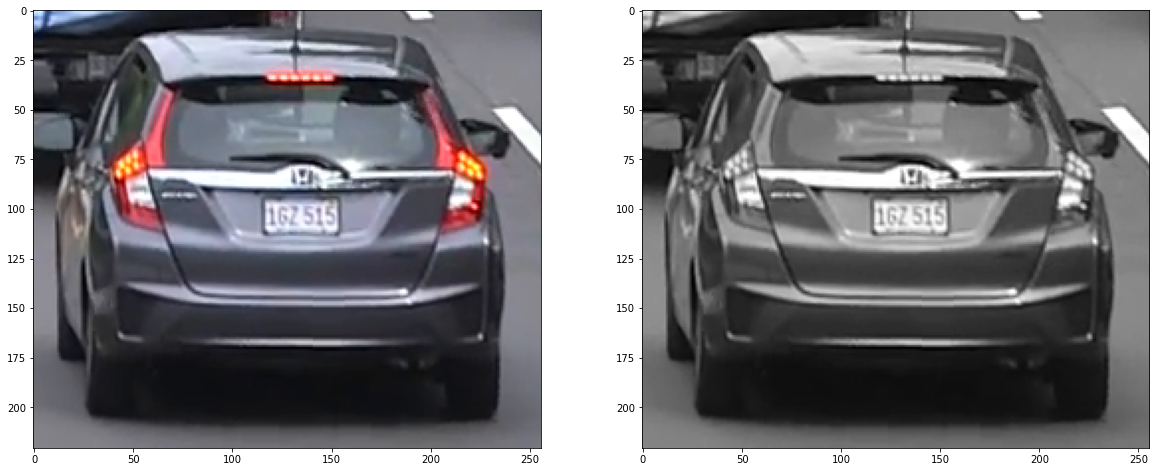

In [2]:

image = cv2.imread('images/car_base.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray= cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(image)
ax2.imshow(gray, cmap='gray')

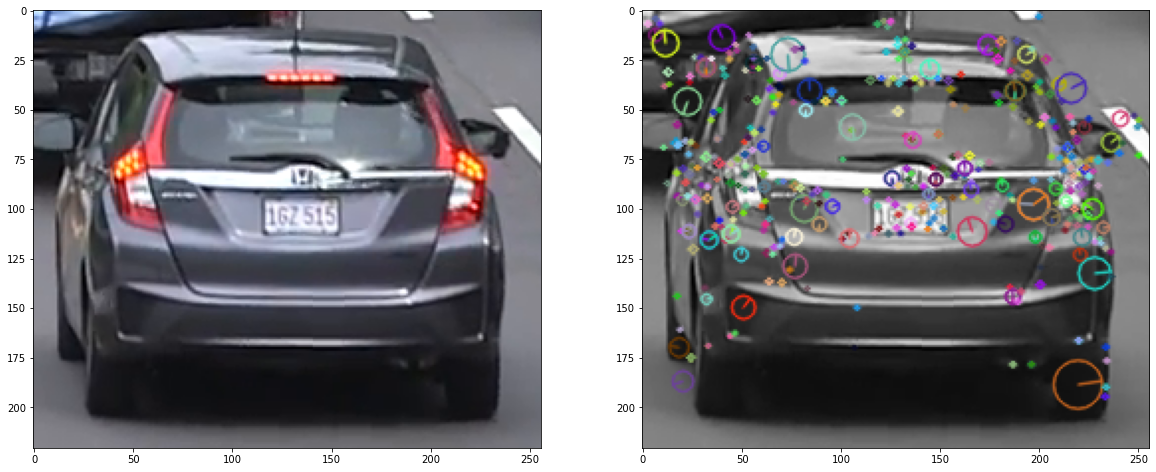

In [3]:
# First we have to construct a SIFT object. We can pass different parameters to it which are optional and they are well explained in docs.
sift = cv2.SIFT_create()

# sift.detectAndCompute() function finds the keypoints and descriptors in the images. You can pass a mask if you want to search only a part of image. Each keypoint is a special structure which has many attributes like its (x,y) coordinates, size of the meaningful neighbourhood, angle which specifies its orientation, response that specifies strength of keypoints etc.
kp, desc = sift.detectAndCompute(gray,None)

image_copy = np.copy(image)

# OpenCV also provides cv.drawKeyPoints() function which draws the small circles on the locations of keypoints. If you pass a flag, cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to it, it will draw a circle with size of keypoint and it will even show its orientation
cv2.drawKeypoints(gray, kp, image_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(image)
ax2.imshow(image_copy, cmap='gray')

### Feature matching
---

OpenCV has two main feature matching algorithms: Brute-force matcher and FLANN matcher.

#### Brute-Force Matcher

Brute-Force (BF) matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

For BF matcher, first we have to create the BFMatcher object using cv2.BFMatcher(). It takes two optional params. First one is *normType*. It specifies the distance measurement to be used. By default, it is cv2.NORM_L2 (Euclidian distance: $d(p,q) = \sqrt{\sum_{i=1}^n (q_i - p_i)^2}$).

Second param is boolean variable, *crossCheck* which is false by default. If it is true, Matcher returns only those matches with value $(i,j)$ such that $i$-th descriptor in set A has $j$-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistent result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper.

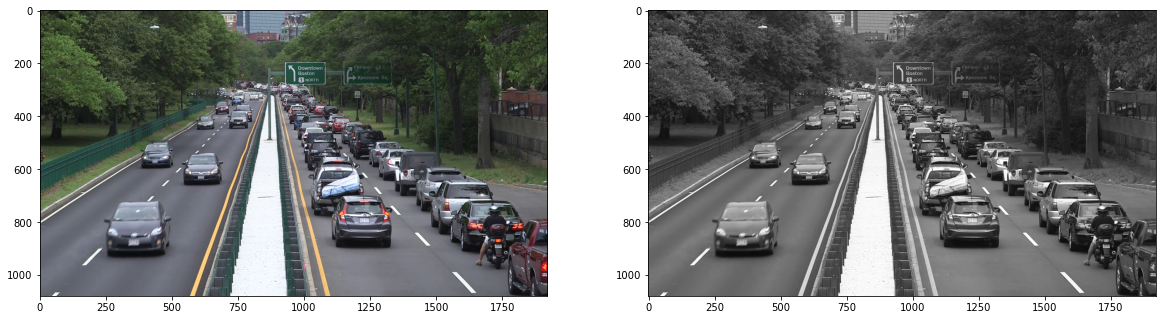

In [4]:
# We first need to compute the descriptors for the image where we want to find an object.
image_compare = cv2.imread('images/cars_traffic.png')
image_compare = cv2.cvtColor(image_compare, cv2.COLOR_BGR2RGB)
gray_compare = cv2.cvtColor(image_compare,cv2.COLOR_RGB2GRAY)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(image_compare)
ax2.imshow(gray_compare, cmap='gray')

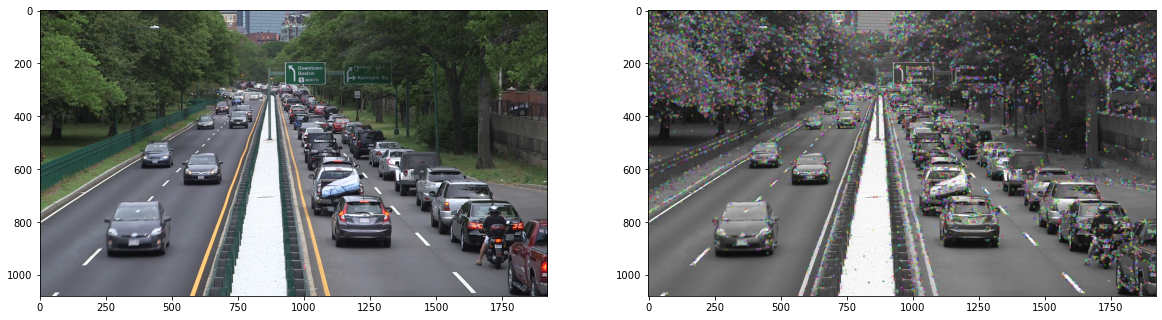

In [5]:
sift = cv2.SIFT_create()

kp_compare, desc_compare = sift.detectAndCompute(gray_compare,None)

image_copy_compare = np.copy(image_compare)

cv2.drawKeypoints(gray_compare, kp_compare, image_copy_compare)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(image_compare)
ax2.imshow(image_copy_compare, cmap='gray')

In Jupyter or IPython notebook, a magic “timeit” command is available to time your code. Timeit magic command in the Jupyter notebook is used to measure the time execution of small code. You don’t need to import the timeit module from a standard library. The “timeit” command starts with the “%” and “%%” symbols. The first one measures the execution time of a single line, while the second measures the execution time of an entire cell.

In [6]:
%%timeit
bf = cv2.BFMatcher()

# Once it is created, two important methods are BFMatcher.match() and BFMatcher.knnMatch(). First one returns the best match. Second method returns k best matches where k is specified by the user. It may be useful when we need to do additional work on that.
matches = bf.match(desc,desc_compare)

19.2 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
matches = sorted(matches, key = lambda x:x.distance, reverse=True)

print(len(matches))

good_matches = list(filter(lambda x: x.distance < 10, matches))

print(len(good_matches))

image_results = cv2.drawMatches(gray, kp, gray_compare, kp_compare, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(20,20))
plt.imshow(image_results)

NameError: name 'matches' is not defined

With the keypoints we obtained, we can calculate a bounding box to detect the object in the image.

In [ ]:
def find_min_max(matches):

    x_min = y_min = float('inf')
    x_max = y_max = 0

    for match in matches:
        point = kp_compare[match.trainIdx].pt
        if point[0] < x_min: x_min = point[0]
        if point[1] < y_min: y_min = point[1]
        if point[0] > x_max: x_max = point[0]
        if point[1] > y_max: y_max = point[1]

    return (int(x_min), int(y_min)), (int(x_max), int(y_max))

In [ ]:
%%timeit 
p_min, p_max = find_min_max(good_matches)

127 µs ± 9.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%timeit
points = [kp_compare[match.trainIdx].pt for match in good_matches]
X = [p[0] for p in points]
Y = [p[1] for p in points]

p_min = (int(min(X)), int(min(Y)))
p_max = (int(max(X)), int(max(Y)))

121 µs ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
# Once we have the minimum and maximum points, we can draw a bounding box.
print(p_min, p_max)
box_image = np.copy(image_compare)

cv2.rectangle(box_image, p_min, p_max, (0, 255, 255), 3)

fig = plt.figure(figsize=(20,10))
plt.imshow(box_image, cmap='gray')

(1099, 696) (1338, 884)


391


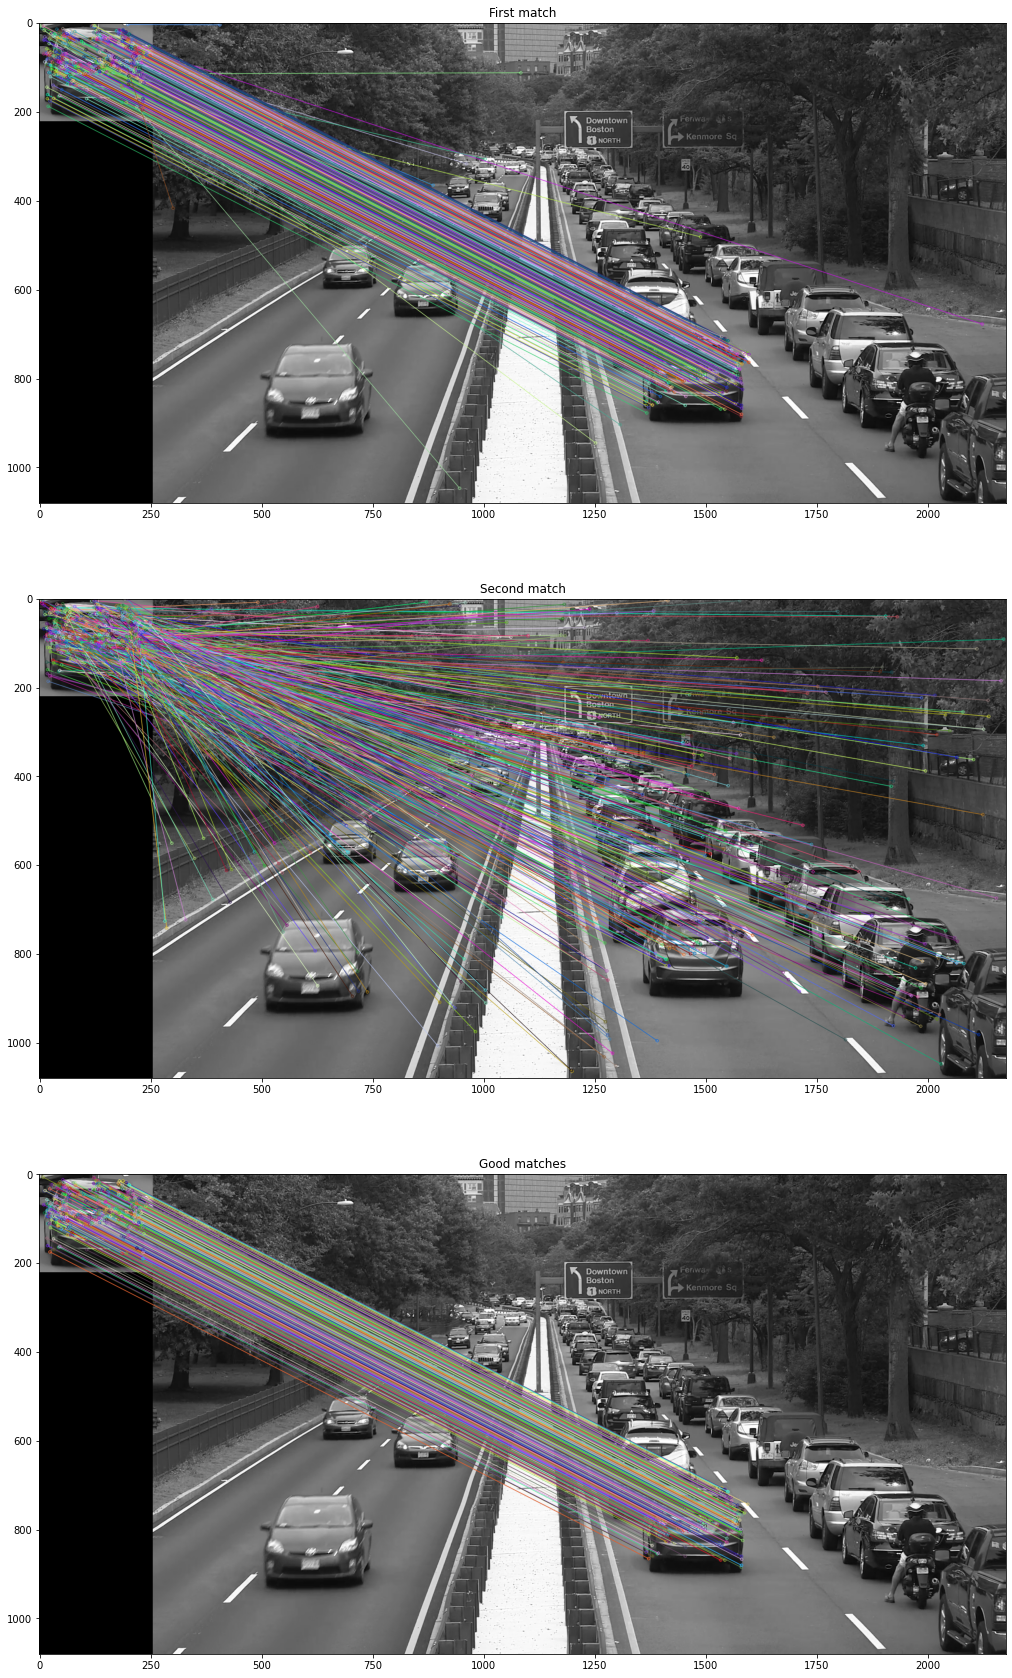

In [ ]:
bf_knn = cv2.BFMatcher()

knn_matches = bf.knnMatch(desc, desc_compare, k=2)

first_match = [m for m,n in knn_matches]
second_match = [n for m,n in knn_matches]
knn_good_matches = [m for m,n in knn_matches if m.distance < 0.05*n.distance]

print(len(knn_good_matches))

image_results_f = cv2.drawMatches(gray, kp, gray_compare, kp_compare, first_match, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
image_results_s = cv2.drawMatches(gray, kp, gray_compare, kp_compare, second_match, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
image_results_g = cv2.drawMatches(gray, kp, gray_compare, kp_compare, knn_good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

f, (ax_f, ax_s, ax_g) = plt.subplots(3, 1, figsize=(20,30))
ax_f.set_title('First match')
ax_f.imshow(image_results_f)
ax_s.set_title('Second match')
ax_s.imshow(image_results_s)
ax_g.set_title('Good matches')
ax_g.imshow(image_results_g)

(1099, 696) (1338, 884)


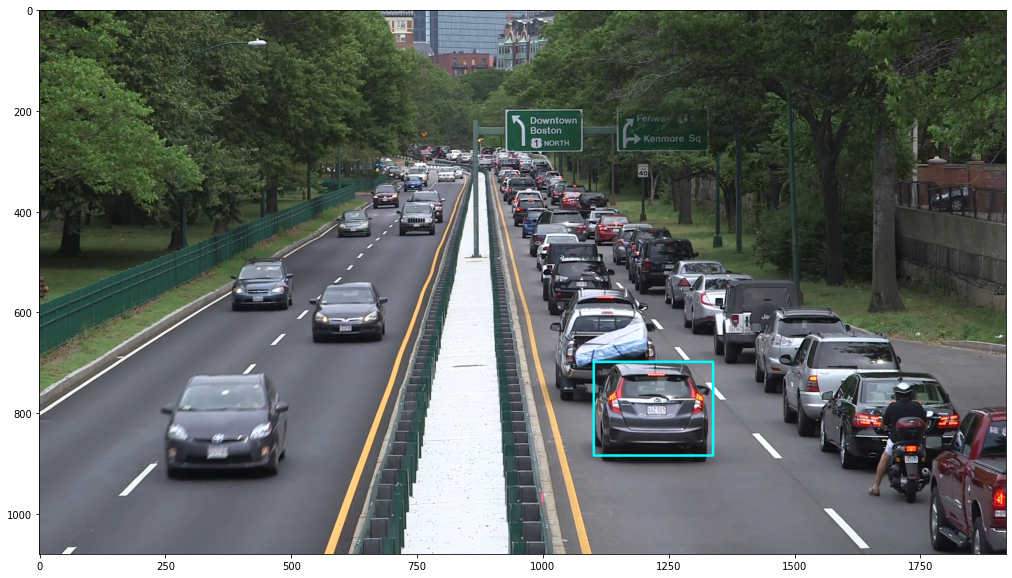

In [ ]:
p_min, p_max = find_min_max(knn_good_matches)
print(p_min, p_max)

box_image_knn = np.copy(image_compare)

cv2.rectangle(box_image_knn, p_min, p_max, (0, 255, 255), 3)

fig = plt.figure(figsize=(20,10))
plt.imshow(box_image, cmap='gray')

#### FLANN based Matcher

FLANN stands for Fast Library for Approximate Nearest Neighbors. It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. It works faster than BFMatcher for large datasets.

For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters etc. First one is IndexParams. For various algorithms, the information to be passed is explained in FLANN docs. The second dictionary is the SearchParams. It specifies the number of times the trees in the index should be recursively traversed. Higher values gives better precision, but also takes more time. If you want to change the value, pass search_params = dict(checks=100).

As a summary, for algorithms like SIFT. you can pass following:

In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

In [ ]:
%%timeit
flann = cv2.FlannBasedMatcher(index_params,search_params)

flann_matches = flann.match(desc, desc_compare)

112 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


388


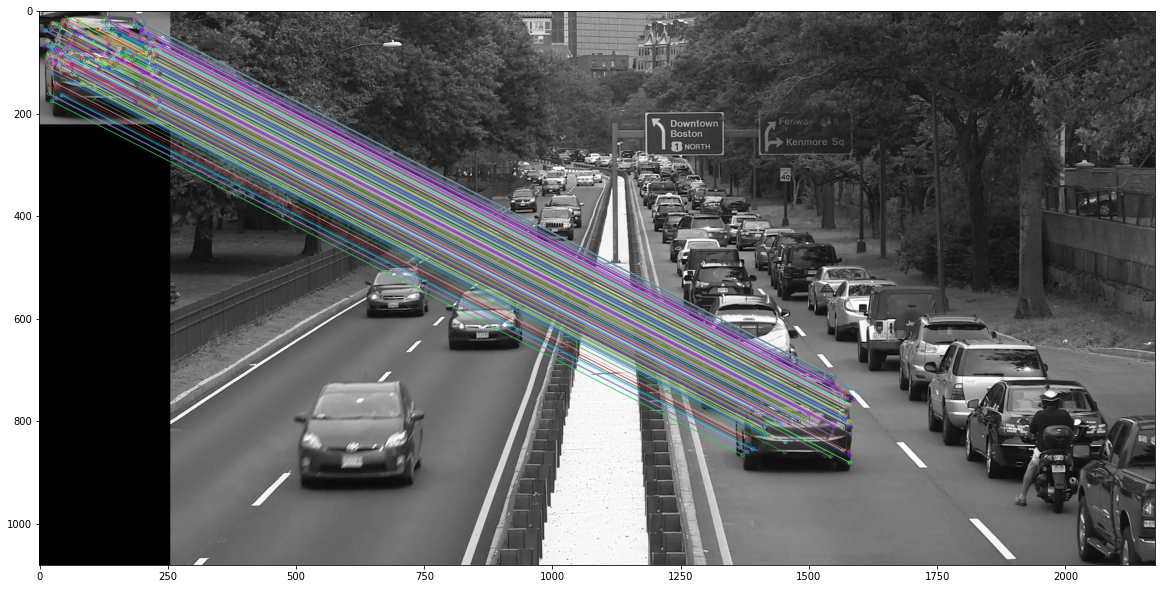

In [ ]:
flann_matches = sorted(flann_matches, key = lambda x:x.distance, reverse=True)

flann_good_matches = list(filter(lambda x: x.distance < 5, flann_matches))

print(len(flann_good_matches))

image_results_flann = cv2.drawMatches(gray, kp, gray_compare, kp_compare, flann_good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(20,20))
plt.imshow(image_results_flann)

#### Detecting multiple objects in an image

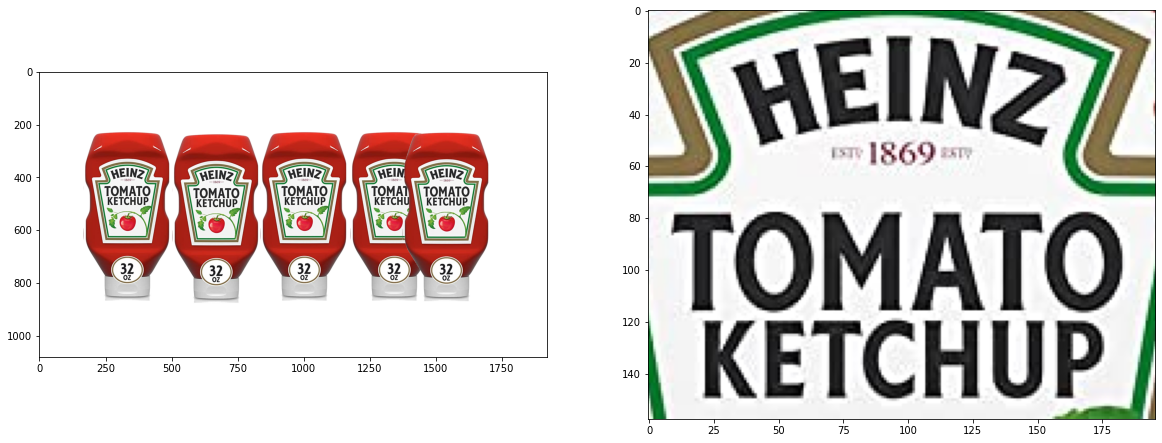

In [ ]:
bottles = cv2.imread('images/ketchup_bottles_multiple.png')
bottles_query = cv2.imread('images/ketchup_query.png')

bottles = cv2.cvtColor(bottles, cv2.COLOR_BGR2RGB)
bottles_query = cv2.cvtColor(bottles_query, cv2.COLOR_BGR2RGB)

bottles_gray = cv2.cvtColor(bottles, cv2.COLOR_RGB2GRAY)
bottles_query_gray = cv2.cvtColor(bottles_query, cv2.COLOR_RGB2GRAY)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(bottles)
ax2.imshow(bottles_query)

In [ ]:
sift = cv2.SIFT_create()

kp, desc = sift.detectAndCompute(bottles,None)
kp_query, desc_query = sift.detectAndCompute(bottles_query,None)

In [ ]:
bf = cv2.BFMatcher()

matches = bf.match(desc_query, desc)

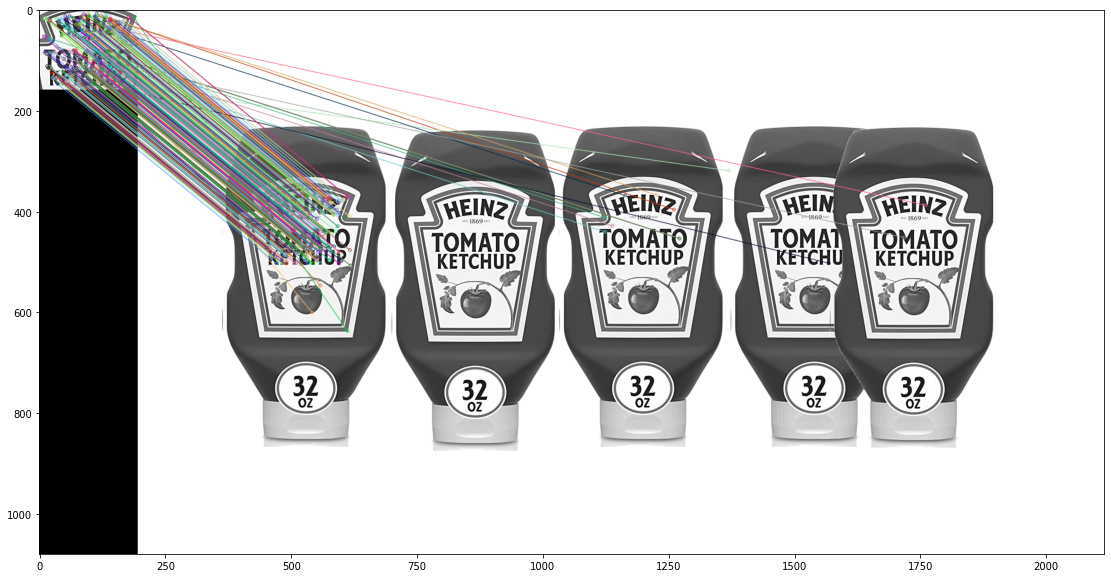

In [ ]:
matches = sorted(matches, key = lambda x:x.distance, reverse=True)
good_matches = list(filter(lambda x: x.distance < 0.01, matches))

image_results = cv2.drawMatches(bottles_query_gray, kp_query, bottles_gray, kp, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(20,10))
plt.imshow(image_results)